<a href="https://colab.research.google.com/github/PGM-Lab/2023-RateFunction/blob/main/Figure7_and_Figure8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!sudo apt-get update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from tqdm import tqdm

from google.colab import files
import pickle

In [77]:


import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from matplotlib.pyplot import figure
def non_latex_format():
  mpl.rcParams.update(mpl.rcParamsDefault)

  matplotlib.rcParams['pdf.fonttype'] = 42
  matplotlib.rcParams['ps.fonttype'] = 42
  plt.rcParams['figure.figsize'] = (16, 9)
  fontsize = 26
  matplotlib.rcParams.update({'font.size': fontsize})

def latex_format():
  plt.rcParams.update({
      'font.size': 10,
      'text.usetex': True,
      'text.latex.preamble': r'\usepackage{amsfonts}\usepackage{bm}'
  })
  mpl.rc('font',family='Times New Roman')
  matplotlib.rcParams['pdf.fonttype'] = 42
  matplotlib.rcParams['ps.fonttype'] = 42
  plt.rcParams['figure.figsize'] = (16, 9)
  fontsize = 30
  matplotlib.rcParams.update({'font.size': fontsize})
latex_format()

In [4]:
criterion = nn.CrossEntropyLoss() # supervised classification loss
criterion_nonreduced = nn.CrossEntropyLoss(reduce=False) # supervised classification loss

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [5]:
!nvidia-smi

Sat Nov  4 13:14:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set-Up

In [6]:
# LENET parameters
RANDOM_SEED = 2147483647
LEARNING_RATE = 0.01 #0.0001 for MLP
SUBSET_SIZE = 50000
TEST_SUBSET_SIZE = 10000
N_ITERS = 2000000
BATCH_SIZE = 200
BATCH_SIZE_TEST = 1000


IMG_SIZE = 32
N_CLASSES = 10

#Set to zero to disconnect L2.
weight_decay = 0.01

setting_name=f"overparam_rs_{RANDOM_SEED}_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{BATCH_SIZE}_wd_{weight_decay}"
setting_name

'overparam_rs_2147483647_lr_0.01_trainsize_50000_testsize_10000_niters_2000000_batchsize_200_wd_0.01'

In [7]:
use_cifar = True
use_mnist = False

In [8]:
!mkdir sgd_images

mkdir: cannot create directory ‘sgd_images’: File exists


# Data

In [9]:
# setup devices
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    device = torch.device("cpu")



transforms = torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             #torchvision.transforms.CenterCrop(IMG_SIZE),
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])



In [10]:
!nvidia-smi

Sat Nov  4 13:14:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:

train_dataset = datasets.CIFAR10(root='cifar_data',
                                train=True,
                                transform=transforms,
                                download=True)

test_dataset = datasets.CIFAR10(root='cifar_data',
                                train=False,
                                transform=transforms)


Files already downloaded and verified


In [12]:
train_dataset = torch.utils.data.Subset(train_dataset, list(range(0, SUBSET_SIZE)))
test_dataset = torch.utils.data.Subset(test_dataset, list(range(0, TEST_SUBSET_SIZE)))

In [13]:
test_loader_batch = torch.utils.data.DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE_TEST,
                          shuffle=False)

# Model

In [14]:
from torchvision.models import resnet50

def createmodel(k):
  torch.manual_seed(RANDOM_SEED)
  torch.cuda.manual_seed(RANDOM_SEED)
  return LeNet5(10, train_dataset[0][0].shape[0], k)

In [15]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, input_channels, k):
        super(LeNet5, self).__init__()

        self.part1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=int(6*k), kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            )
        self.part2 = nn.Sequential(
            nn.Conv2d(in_channels=int(6*k), out_channels=int(16*k), kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            )
        self.part3 = nn.Sequential(
            nn.Conv2d(in_channels=int(16*k), out_channels=int(120*k), kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=int(120*k), out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.part1(x)
        x = self.part2(x)
        x = self.part3(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

# Code

In [16]:
def get_log_p(device, model, loader):
    cce = nn.CrossEntropyLoss(reduction = "none") # supervised classification loss
    model.eval()
    aux = []
    with torch.no_grad():
      for data, targets in loader:
          data = data.to(device)
          targets = targets.to(device)
          logits = model(data)
          probs = F.softmax(logits, dim=1)
          log_p = -cce(logits, targets) # supervised loss
          aux.append(log_p)
    return torch.cat(aux)

In [17]:
#Binary Search for lambdas
def rate_function_BS(model, s_value):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, test_loader_batch)
  return aux_rate_function_TernarySearch(log_p, s_value, min_lamb, max_lamb, 0.001)

def eval_log_p(log_p, lamb, s_value):
  jensen_val=(torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb *torch.mean(log_p))
  return lamb*s_value - jensen_val

def aux_rate_function_BinarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
      mid = (low + high) / 2
      print(mid)
      print(eval_log_p(log_p, low, s_value))
      print(eval_log_p(log_p, mid, s_value))
      print(eval_log_p(log_p, high, s_value))
      print("--")
      if eval_log_p(log_p, mid, s_value) < eval_log_p(log_p, high, s_value):
          low = mid
      else:
          high = mid

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


def aux_rate_function_TernarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
    mid1 = low + (high - low) / 3
    mid2 = high - (high - low) / 3

    if eval_log_p(log_p, mid1, s_value) < eval_log_p(log_p, mid2, s_value):
        low = mid1
    else:
        high = mid2

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]

import math
def aux_rate_function_golden_section_search(log_p, s_value, a, b, epsilon):
    """
    Maximizes a univariate function using the golden section search algorithm.

    Parameters:
        f (function): The function to minimize.
        a (float): The left endpoint of the initial search interval.
        b (float): The right endpoint of the initial search interval.
        tol (float): The error tolerance value.

    Returns:
        float: The x-value that minimizes the function f.
    """
    # Define the golden ratio
    golden_ratio = (torch.sqrt(torch.tensor(5).to(device)) - 1) / 2

    # Define the initial points
    c = b - golden_ratio * (b - a)
    d = a + golden_ratio * (b - a)

    # Loop until the interval is small enough
    while abs(c - d) > epsilon:
        # Compute the function values at the new points
        fc = eval_log_p(log_p, c, s_value)
        fd = eval_log_p(log_p, d, s_value)

        # Update the interval based on the function values
        if fc > fd:
            b = d
            d = c
            c = b - golden_ratio * (b - a)
        else:
            a = c
            c = d
            d = a + golden_ratio * (b - a)

    # Return the midpoint of the final interval
    mid = (a + b) / 2
    return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


In [18]:
def eval_jensen(model, lambdas):
  log_p = get_log_p(device, model, test_loader_batch)
  return np.array(
      [
          (torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - torch.mean(lamb * log_p)).detach().cpu().numpy() for lamb in lambdas
       ])

def inverse_rate_function(model, lambdas, rate_vals):
  jensen_vals = eval_jensen(model, lambdas)

  return np.array([ np.min((jensen_vals + rate)/lambdas) for rate in rate_vals])


In [19]:
def eval(device, model, loader, criterion):
    correct = 0
    total = 0
    losses = 0
    model.eval()
    with torch.no_grad():
        for data, targets in loader:
            total += targets.size(0)
            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            probs = F.softmax(logits, dim=1)
            predicted = torch.argmax(probs, 1)
            correct += (predicted == targets).sum().detach().cpu().numpy()

            loss = criterion(logits, targets) # supervised loss
            losses += loss.detach().cpu().numpy() * targets.size(0)

    return correct, total, losses/total

In [20]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [63]:
SKIP=False
lambdas = np.arange(-10, 10, 0.01)

def train(model, train_loader):
    es = EarlyStopper(patience = 2)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose = False)
    data_iter = iter(train_loader)
    iters_per_epoch = len(data_iter)
    aux_loss = 1
    tq = tqdm(range(N_ITERS))
    for it in tq:

            model.train()

            try:
                inputs, target = next(data_iter)
            except StopIteration:
                # StopIteration is thrown if dataset ends
                # reinitialize data loader
                data_iter = iter(train_loader)
                inputs, target = next(data_iter)


            inputs = inputs.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            logits = model(inputs) # forward pass

            loss = criterion(logits, target) # supervised loss
            aux_loss += loss.detach().cpu().numpy()

            tq.set_postfix({'Train cce': loss.detach().cpu().numpy(),
                            "Patience": es.counter})


            loss.backward() # computes gradients
            optimizer.step()

            if it % iters_per_epoch == 0 and it != 0:
              scheduler.step()
              if aux_loss/iters_per_epoch < 0.01 or es.early_stop(aux_loss):
                break
              aux_loss = 0



    return model

# Training

In [64]:
ks = np.arange(0.2, 5, step = 0.1)

In [65]:
ks

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4,
       1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
       2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ,
       4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])

In [66]:
models = [createmodel(k).to(device) for k in ks]

In [67]:
n_params = []
for model in models:
  n = 0
  for parameter in model.parameters():
    n += parameter.flatten().size(0)
  n_params.append(n)

In [68]:
jet = plt.cm.get_cmap('Dark2')

<ipython-input-68-92d3b638b2ea>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('Dark2')


In [69]:
labels = ["ConvNN-3k", "ConvNN-9k", "ConvNN-18k", "ConvNN-62k", "ConvNN-130k", "ConvNN-223k","ConvNN-342k","ConvNN-486k","ConvNN-655k","ConvNN-850k","ConvNN-1069K"]


In [144]:
labels = ["ConvNN-"+str(p//1000)+"k" for p in n_params]
labels

['ConvNN-4k',
 'ConvNN-7k',
 'ConvNN-12k',
 'ConvNN-18k',
 'ConvNN-24k',
 'ConvNN-32k',
 'ConvNN-39k',
 'ConvNN-50k',
 'ConvNN-62k',
 'ConvNN-71k',
 'ConvNN-85k',
 'ConvNN-96k',
 'ConvNN-112k',
 'ConvNN-130k',
 'ConvNN-143k',
 'ConvNN-163k',
 'ConvNN-178k',
 'ConvNN-200k',
 'ConvNN-223k',
 'ConvNN-241k',
 'ConvNN-266k',
 'ConvNN-285k',
 'ConvNN-313k',
 'ConvNN-342k',
 'ConvNN-363k',
 'ConvNN-395k',
 'ConvNN-417k',
 'ConvNN-451k',
 'ConvNN-486k',
 'ConvNN-511k',
 'ConvNN-548k',
 'ConvNN-575k',
 'ConvNN-614k',
 'ConvNN-655k',
 'ConvNN-684k',
 'ConvNN-727k',
 'ConvNN-758k',
 'ConvNN-803k',
 'ConvNN-850k',
 'ConvNN-883k',
 'ConvNN-931k',
 'ConvNN-966k',
 'ConvNN-1017k',
 'ConvNN-1069k',
 'ConvNN-1106k',
 'ConvNN-1161k',
 'ConvNN-1199k',
 'ConvNN-1256k']

In [71]:
results = []
for i in range(len(models)):
  g_cuda = torch.Generator(device='cpu')
  g_cuda.manual_seed(RANDOM_SEED)
  loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          generator=g_cuda,
                          shuffle=True)
  results.append(train(models[i], loader))
  with open(f'sgd_images/{setting_name}_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 10000/2000000 [11:49<39:12:24, 14.10it/s, Train cce=0.008607309, Patience=0]


In [72]:
with open(f"sgd_images/{setting_name}_results.pickle", "rb") as handle:
  results = pickle.load(handle)

In [108]:
train_loss = []
test_loss = []
for i in range(len(models)):
  loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
  train_loss.append(eval(device, results[i],  loader, criterion)[2])
  test_loss.append(eval(device, results[i],  test_loader_batch, criterion)[2])

In [110]:
print(train_loss)

[1.5409572973251342, 1.3867206377983092, 1.2106102170944213, 1.0502703475952149, 0.9505761518478394, 0.8357551434040069, 0.7825550625324249, 0.6641855912208557, 0.5723822169303894, 0.5246615195274353, 0.41714798378944395, 0.3738466868400574, 0.2697388555407524, 0.23184066104888917, 0.1699694014787674, 0.12261360543966293, 0.09947222408652305, 0.057308194369077685, 0.05107117197662592, 0.04468439652770757, 0.03365833492577076, 0.025334190331399442, 0.017768584821373223, 0.016846828613430263, 0.01304417184367776, 0.009965295625850558, 0.010279390472918749, 0.00981197003647685, 0.009799546858295798, 0.009461924966424704, 0.00934179473668337, 0.009412764890119434, 0.00929493403248489, 0.009294563252478839, 0.009044868486002087, 0.009375902995467186, 0.009020096857100725, 0.00906506279297173, 0.00927840475179255, 0.009196554845198988, 0.008954217726364731, 0.008787801869213581, 0.00907972464337945, 0.008883423563092947, 0.008517558129504324, 0.00883651925995946, 0.008242375005036592, 0.0085

In [111]:
print(test_loss)

[1.5678694009780885, 1.449522066116333, 1.3221673846244812, 1.2321093559265137, 1.2039014101028442, 1.1724839091300965, 1.2261703848838805, 1.2208913803100585, 1.1642002582550048, 1.251182746887207, 1.3534278273582458, 1.40519939661026, 1.4886023163795472, 1.454811441898346, 1.696902823448181, 1.8247268080711365, 1.9373388648033143, 2.101435601711273, 2.0119644165039063, 2.045491600036621, 2.1214922428131104, 2.1889012813568116, 2.1803043127059936, 2.0623161435127257, 2.1914767026901245, 2.346987247467041, 2.1809038400650023, 2.263844299316406, 2.096049726009369, 2.170680212974548, 2.1267351865768434, 2.1004386067390444, 2.0923136830329896, 1.92529456615448, 2.0134535908699034, 1.8186829447746278, 1.9416479349136353, 1.9209216713905335, 1.84324551820755, 1.8582587122917176, 1.8061268091201783, 1.7953696370124816, 1.7720836281776429, 1.81825590133667, 1.8608787655830383, 1.7301780939102174, 1.770400059223175, 1.7078184485435486]


In [252]:
latex_format()

In [126]:
N = 7
train_loss_ = *([train_loss[0]]*(N//2)), *train_loss, *([train_loss[-1]]*(N//2))
test_loss_ = *([test_loss[0]]*(N//2)), *test_loss, *([test_loss[-1]]*(N//2))

train_loss_ = np.convolve(train_loss_, np.ones(N)/N, mode = "valid")
test_loss_ = np.convolve(test_loss_, np.ones(N)/N, mode = "valid")

In [266]:
  plt.rcParams['figure.figsize'] = (16, 8)

24


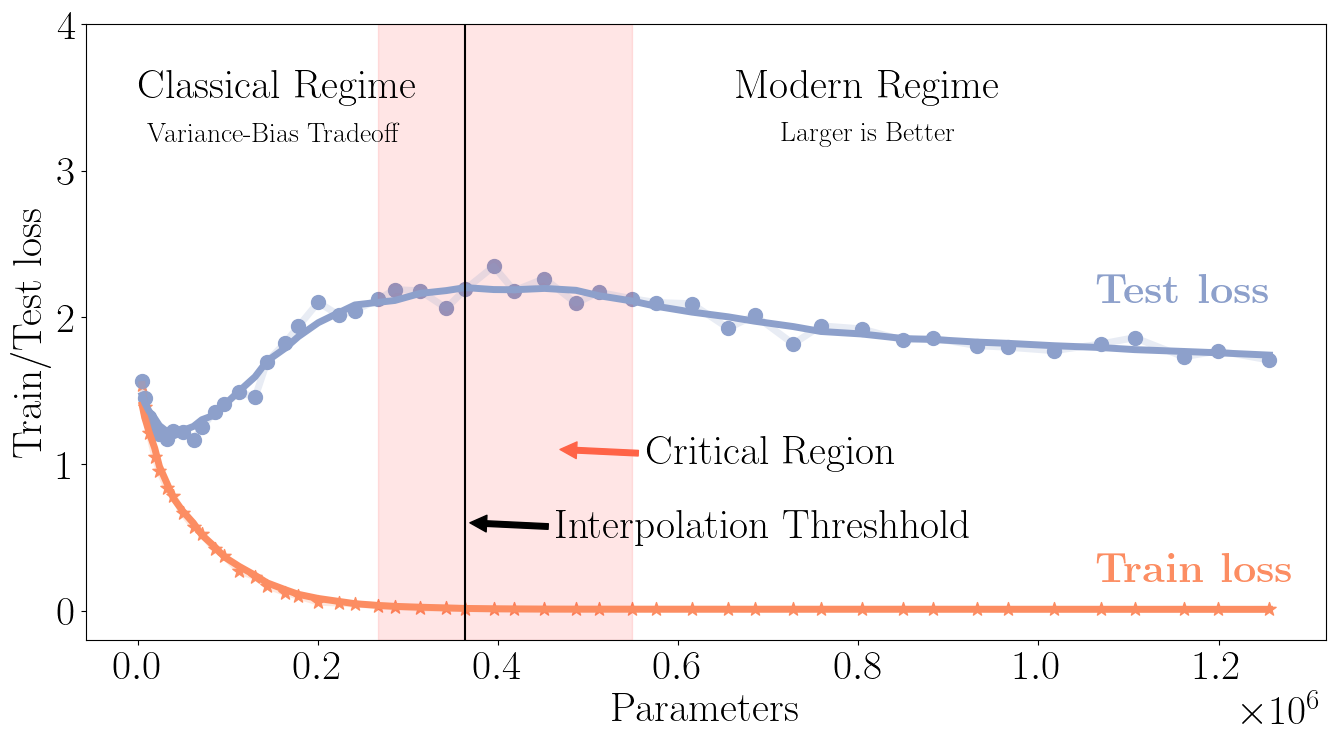

In [267]:
jet = plt.colormaps["Set2"]
lw = 5
plt.plot(n_params, train_loss, linewidth = lw, color = jet(1), alpha = 0.2)
plt.plot(n_params, test_loss, linewidth = lw, color = jet(2), alpha = 0.2)
plt.plot(n_params, train_loss_,  linewidth =lw, color = jet(1))
plt.plot(n_params, test_loss_, linewidth = lw, color = jet(2))
plt.scatter(n_params, train_loss, marker = "*", label = "Train loss", color = jet(1), s = 100)
plt.scatter(n_params, test_loss, marker = "o", label = "Test loss", color = jet(2), s = 100)

max_test = np.argmax(test_loss_)
mask = np.isclose(test_loss_, test_loss_[max_test], 0.05)
min_region = np.where(mask == True)[0][0]
max_region = np.where(mask == True)[0][-1]

print(max_test)
plt.annotate("Classical Regime", xy = (0, 3.5))
plt.annotate("Variance-Bias Tradeoff", xy = (10000, 3.2), fontsize = 20)

plt.annotate("Modern Regime",xy = (n_params[max_region]+200000, 3.5), xytext = (n_params[max_test]+300000, 3.5))
plt.annotate("Larger is Better", xy = (n_params[max_test]+350000, 3.2), fontsize = 20)

plt.annotate("Interpolation Threshhold",xy = (n_params[max_test], 0.6), xytext = (n_params[max_test]+100000, 0.5), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("Critical Region",xy = (n_params[max_test]+100000, 1.1), xytext = (n_params[max_test]+200000, 1), arrowprops=dict(color='tomato', shrink=0.05))


plt.annotate(r"\textbf{Train loss}",xy = (n_params[max_test]+500000, 0.2), xytext = (n_params[max_test]+700000, 0.2), color = jet(1))
plt.annotate(r"\textbf{Test loss}",xy = (n_params[max_test]+500000, 2.1), xytext = (n_params[max_test]+700000, 2.1), color = jet(2))

plt.axvspan(n_params[min_region], n_params[max_region], alpha=0.1, color='red')
plt.vlines(n_params[max_test], ymin = -0.2, ymax =4, color = "black")
plt.ylim(-0.2, 4)
plt.ylabel("Train/Test loss")
plt.xlabel("Parameters")
plt.savefig("sgd_images/double_descent.pdf", format = "pdf",bbox_inches='tight')



# Figure 4: Jensen-Gap Functions Evolution

In [204]:
indexes = np.arange(len(n_params), step = 5)
indexes

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [205]:
for i in indexes:
  print(labels[i])
  loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
  print("Train", eval(device, results[i],  loader, criterion))
  print("Test", eval(device, results[i],  test_loader_batch, criterion))

ConvNN-4k
Train (21929, 50000, 1.5409573097229003)
Test (4284, 10000, 1.5678694009780885)
ConvNN-32k
Train (35470, 50000, 0.8357551512718201)
Test (5976, 10000, 1.1724839091300965)
ConvNN-85k
Train (43367, 50000, 0.41714798092842104)
Test (6296, 10000, 1.3534278273582458)
ConvNN-163k
Train (48862, 50000, 0.12261360645294189)
Test (6378, 10000, 1.8247268080711365)
ConvNN-266k
Train (49928, 50000, 0.033658334836363796)
Test (6501, 10000, 2.1214922428131104)
ConvNN-395k
Train (49999, 50000, 0.00996529576741159)
Test (6585, 10000, 2.346987247467041)
ConvNN-548k
Train (50000, 50000, 0.009341794818639755)
Test (6698, 10000, 2.1267351865768434)
ConvNN-727k
Train (49999, 50000, 0.009375903064385056)
Test (6971, 10000, 1.8186829447746278)
ConvNN-931k
Train (50000, 50000, 0.00895421776175499)
Test (6914, 10000, 1.8061268091201783)
ConvNN-1161k
Train (49999, 50000, 0.008836519207805395)
Test (6976, 10000, 1.7301780939102174)


In [206]:
s_values = np.arange(0, 0.5, 0.01)
lambdas = np.arange(0, 10, 0.01)
Is = []


In [207]:
jensens = [eval_jensen(results[i].to(device), lambdas) for i in indexes]

In [208]:
rates = []
s_values = np.arange(0, 0.5, 0.01)

for i in indexes:
  print(i)
  rates.append(np.array([rate_function_BS(results[i].to(device), s)[0] for s in s_values]))



0
5
10
15
20
25
30
35
40
45


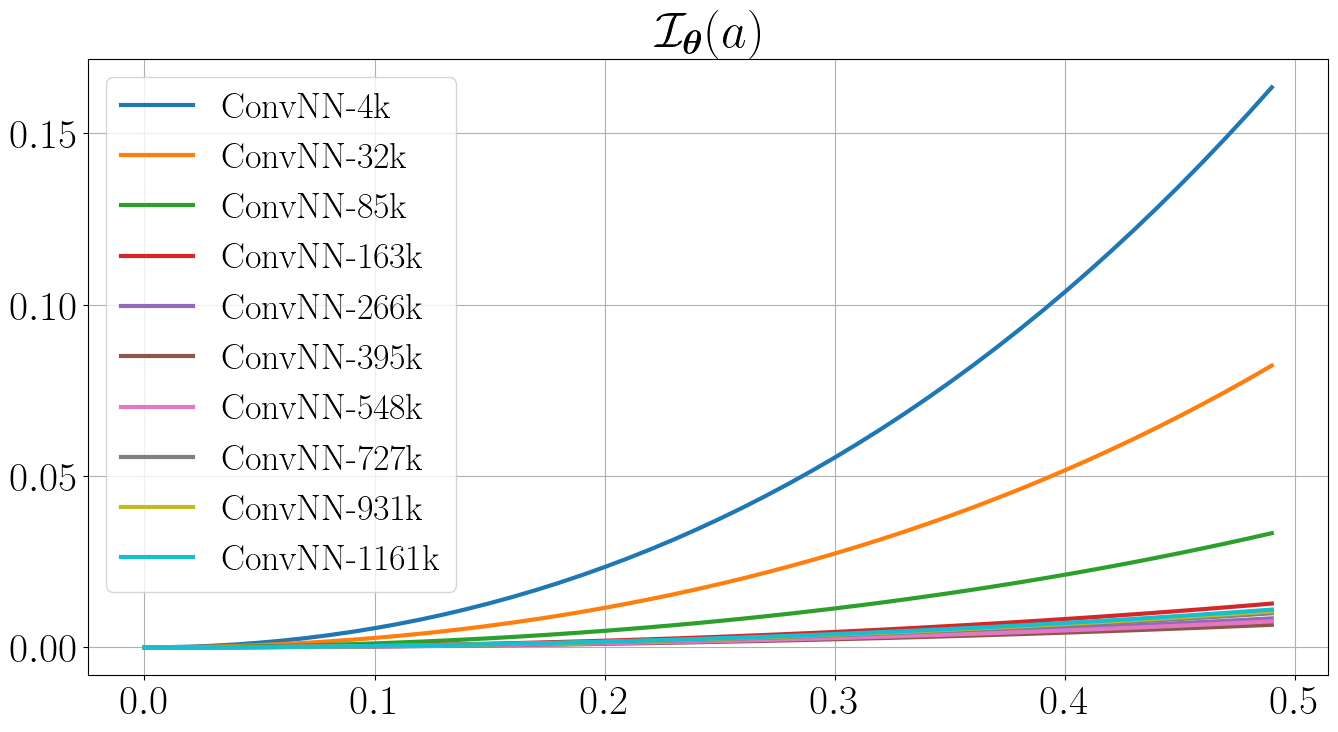

In [263]:
for idx, i in enumerate(indexes):
  plt.plot(s_values, rates[idx], label=labels[i],linewidth=3)#, color = colors[idx], marker = markers[idx],  markersize=15, markevery=5)

plt.legend(fontsize=20, prop={'size': 26})
plt.grid()
plt.title(r"$\mathcal{I}_{\bm \theta}(a)$")
plt.savefig("sgd_images/rate_1.pdf", format = "pdf",bbox_inches='tight')
plt.show()

In [224]:
markers = [8, 9, 10, 11, "+", "o", ">"]
colors = [jet(0), jet(1), jet(2), jet(3), jet(4), jet(6)]

In [272]:
plt.rcParams['figure.figsize'] = (16, 7)
fontsize = 30

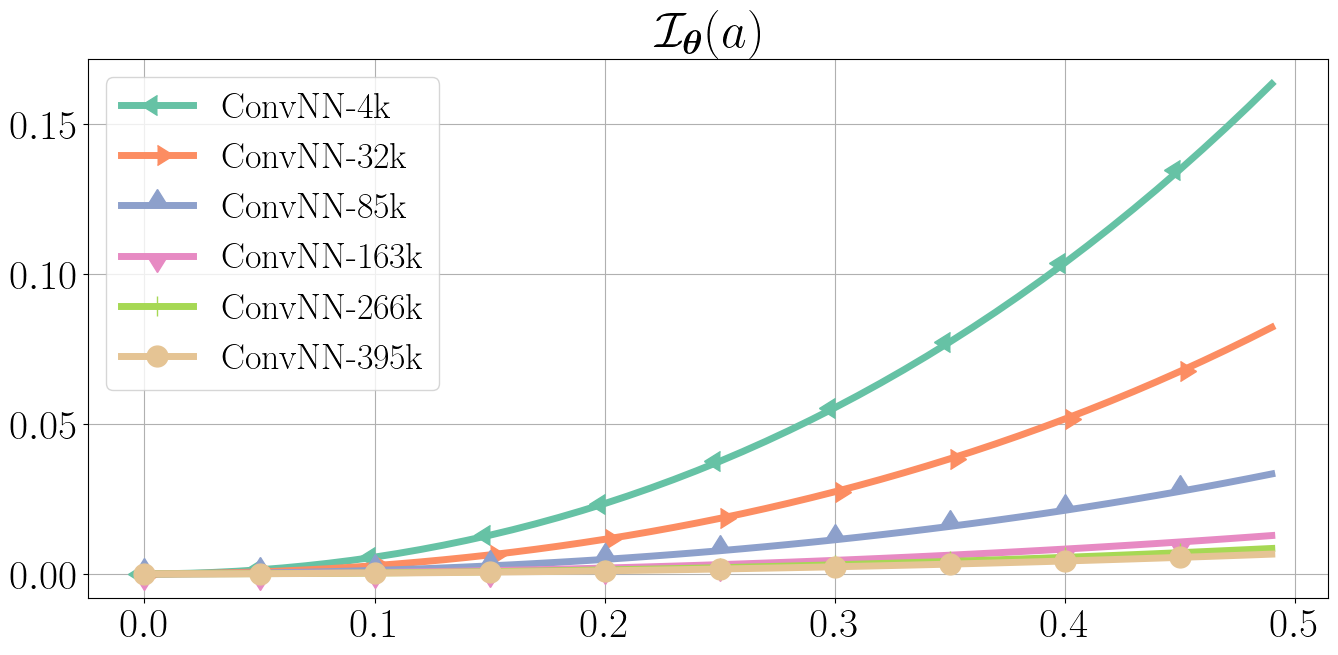

In [273]:
for idx, i in enumerate(indexes[:6]):
  plt.plot(s_values, rates[idx], label=labels[i],linewidth=5, color = colors[idx], marker = markers[idx],  markersize=15, markevery=5)

plt.legend(fontsize=20, prop={'size': 26})
plt.grid()
plt.title(r"$\mathcal{I}_{\bm \theta}(a)$")
plt.savefig("sgd_images/rate_1.pdf", format = "pdf",bbox_inches='tight')
plt.show()

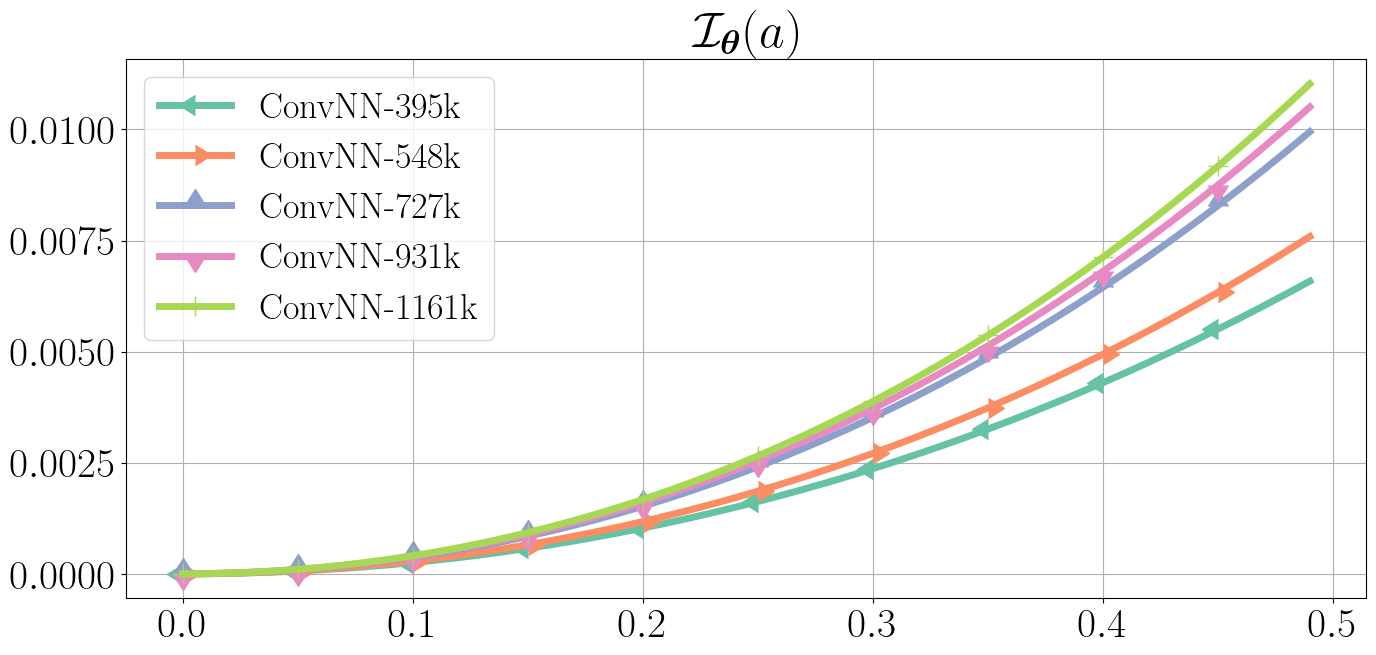

In [274]:
for idx, i in enumerate(indexes[5:]):
  plt.plot(s_values, rates[5+idx], label=labels[i],linewidth=5, color = jet(idx), marker = markers[idx],  markersize=15, markevery=5)

#plt.yticks([0,0.002, 0.005, 0.007, 0.01])

plt.grid()
plt.legend(fontsize=20, prop={'size': 26})
plt.title(r"$\mathcal{I}_{\bm \theta}(a)$")
plt.savefig("sgd_images/rate_2.pdf", format = "pdf",bbox_inches='tight')
plt.show()

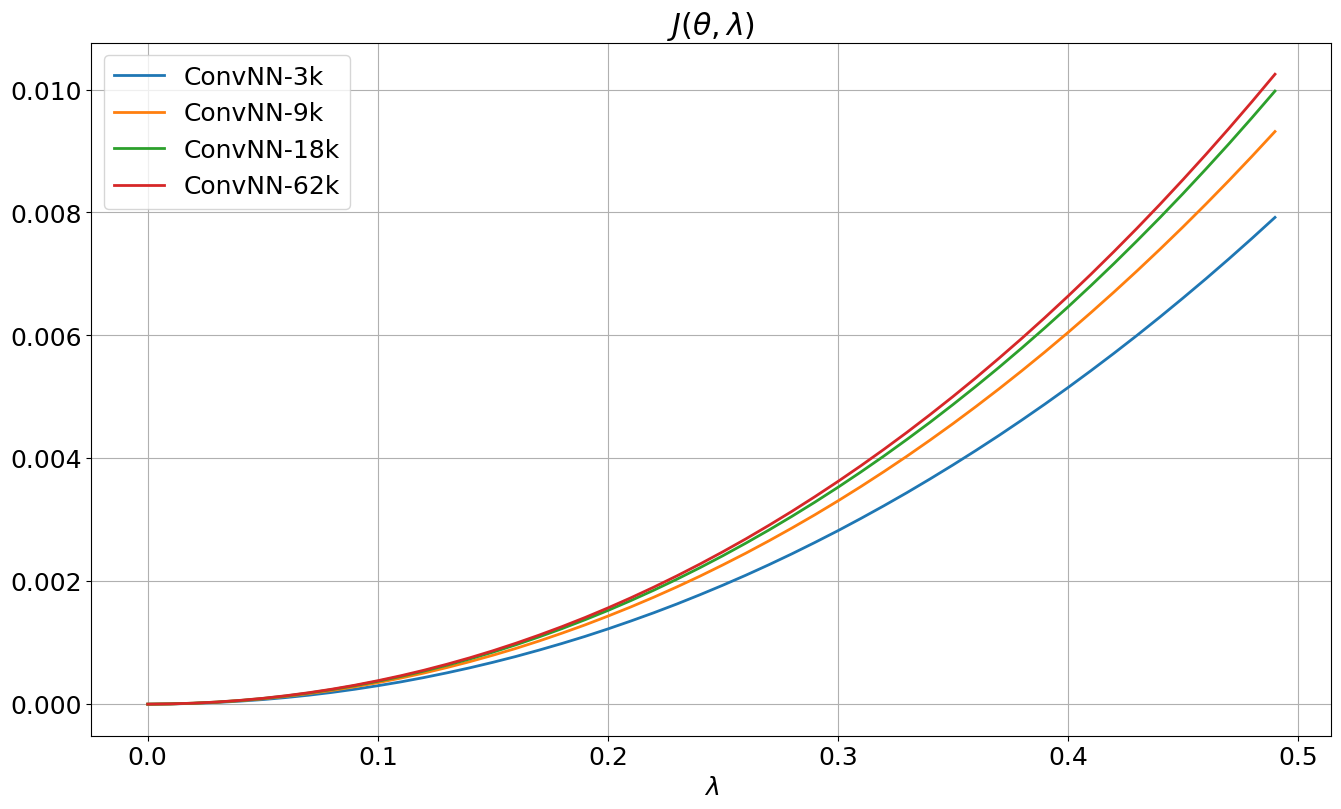

In [ ]:
plt.set_cmap("Dark2")
for i in range(len(Is)):
  plt.plot(s_values, Is[i], label=labels[i] ,linewidth=2)


plt.legend()
plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
#plt.ylim(0,1)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen_overparameterization_1.pdf", format = "pdf",bbox_inches='tight')
plt.show()

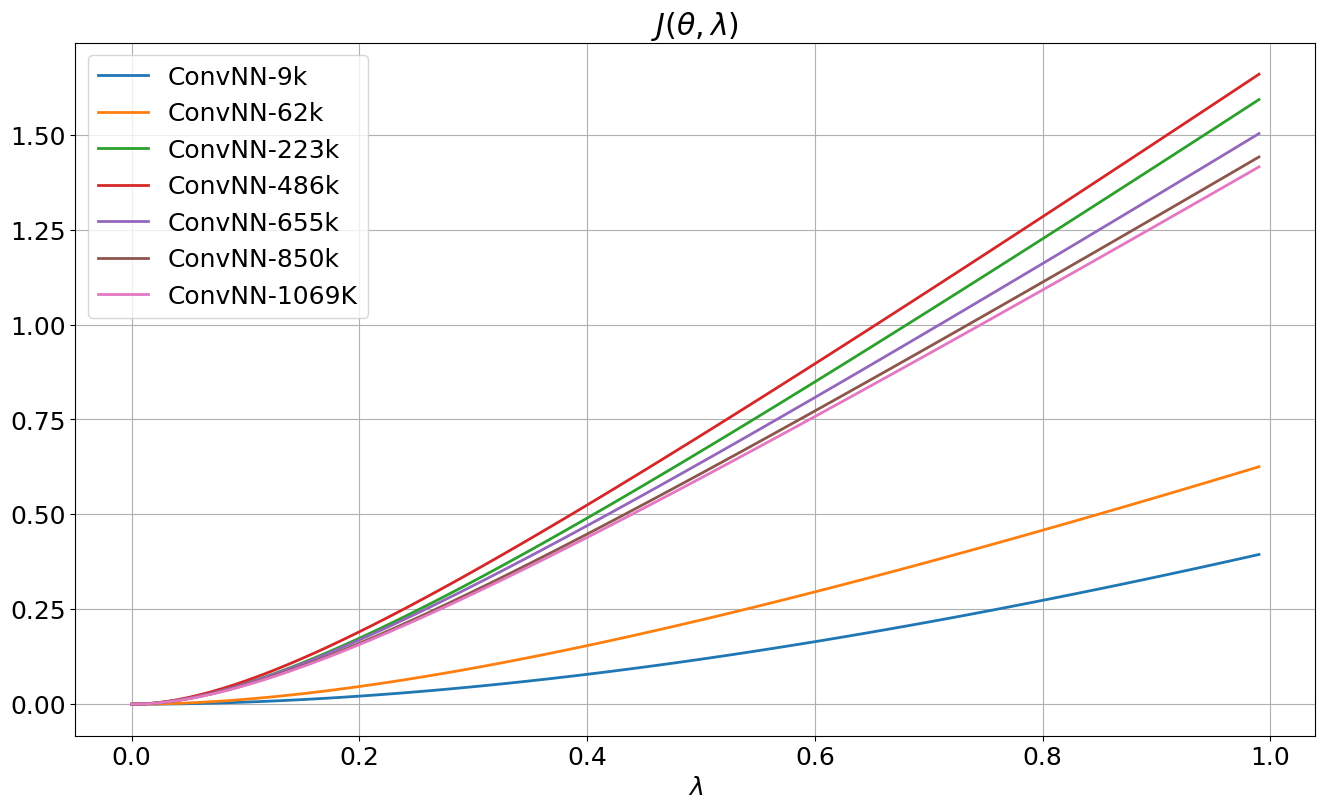

In [ ]:


plt.set_cmap("Dark2")
for i in [1, 3, 5, 7, 8, 9, 10]:
  plt.plot(lambdas, jensens[i], label=labels[i] ,linewidth=2)


plt.legend()
plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
#plt.ylim(0,1)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen_overparameterization_1.pdf", format = "pdf",bbox_inches='tight')
plt.show()

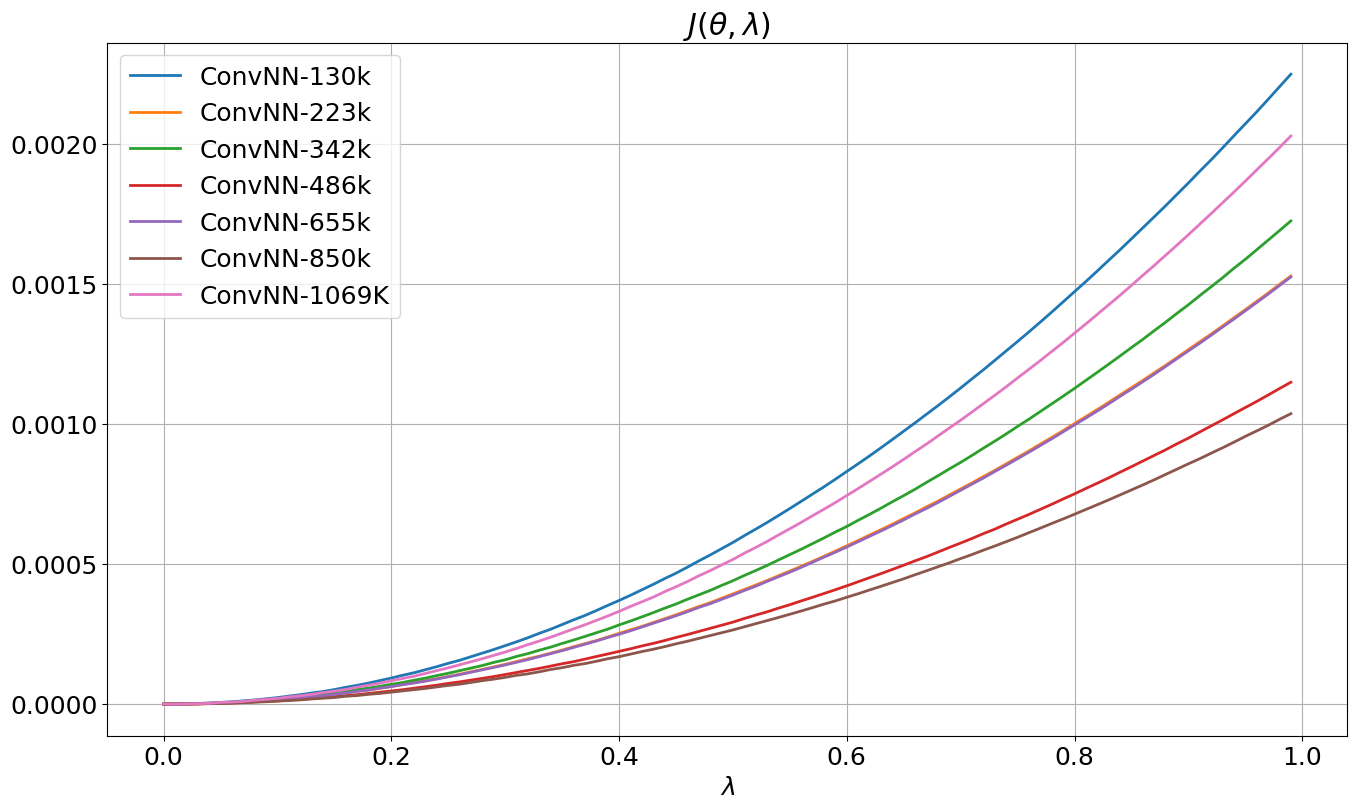

In [ ]:
plt.set_cmap("Dark2")
for i in range(4, len(models)):
  jensen = eval_jensen(models[i].to(device), lambdas)
  plt.plot(lambdas, jensen, label=labels[i] ,linewidth=2)


plt.legend()
plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
#plt.ylim(0,1)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen_overparameterization_2.pdf", format = "pdf",bbox_inches='tight')
plt.show()

# Download Files

In [ ]:
!zip sgd_images/images.zip sgd_images/*.pdf

In [ ]:
files.download('sgd_images/images.zip')

In [ ]:
!ls -l sgd_images